<a href="https://colab.research.google.com/github/KeertikaAnand/NETWORK-INTRUSTION-DETECTION-SYSTEM/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import joblib
import ipywidgets as widgets
from IPython.display import display, HTML
import time
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Cell 2: Mount Google Drive for data persistence
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 3: Define file paths and load datasets
# Set paths (adjust as needed)
drive_path = "/content/drive/My Drive/Network_Attack_Detection/"
train_set_path = drive_path + "UNSW_NB15_training-set.csv"
test_set_path = drive_path + "UNSW_NB15_testing-set.csv"

# Load the data
train_df = pd.read_csv(train_set_path)
test_df = pd.read_csv(test_set_path)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Training set shape: (82332, 45)
Testing set shape: (175341, 45)


In [ ]:
# Cell 4: Data Overview and Missing Values Check
# Check for missing values
print("\nMissing values in the training set:\n", train_df.isnull().sum())
print("\nMissing values in the testing set:\n", test_df.isnull().sum())

# Basic statistics
print("\nTraining Set Statistics:\n", train_df.describe())


Missing values in the training set:
 id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst         

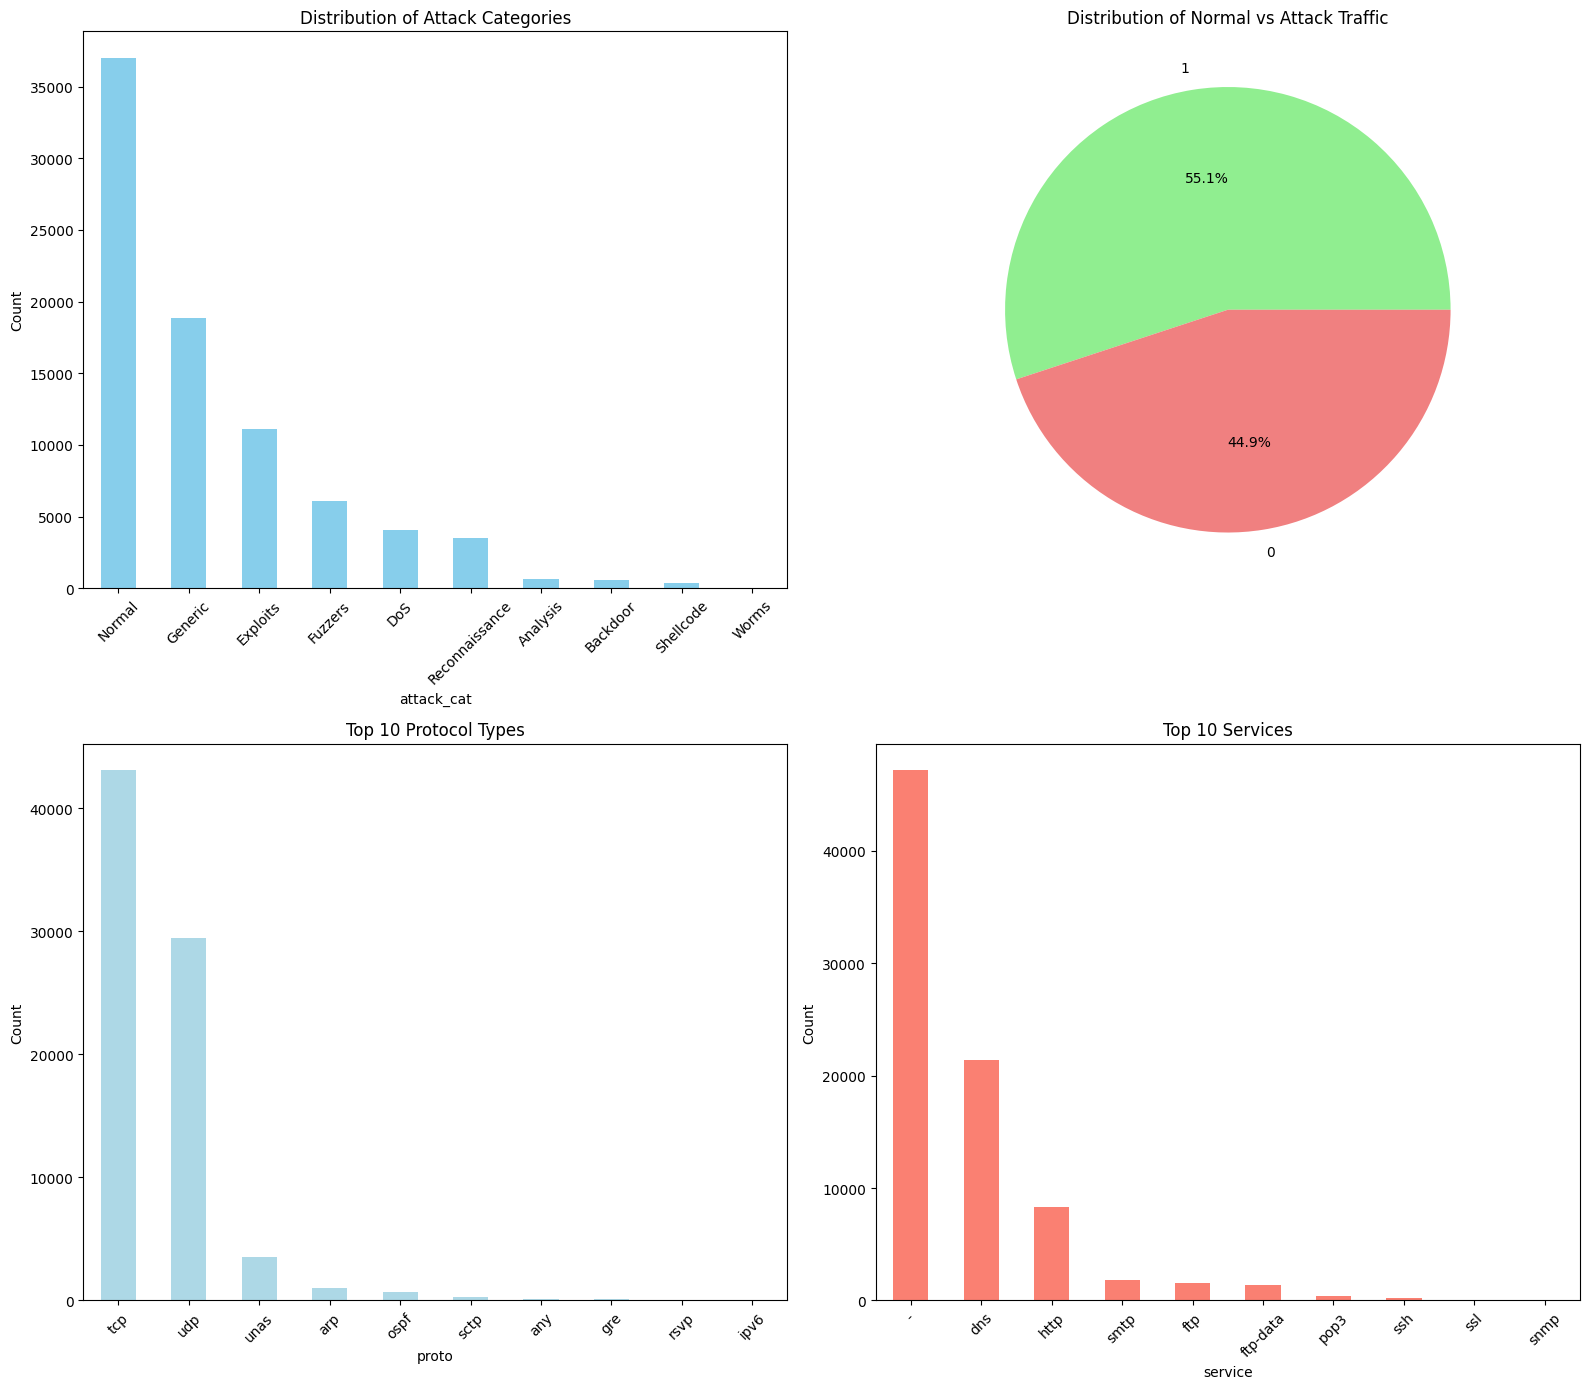

In [ ]:
# Cell 5: Advanced Exploratory Data Analysis (EDA)
# Create a figure for plotting
plt.figure(figsize=(16, 14))

# Plot 1: Distribution of attack categories
plt.subplot(2, 2, 1)
attack_counts = train_df['attack_cat'].value_counts()
attack_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Attack Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 2: Class distribution
plt.subplot(2, 2, 2)
class_counts = train_df['label'].value_counts()
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Distribution of Normal vs Attack Traffic')
plt.ylabel('')

# Plot 3: Protocol distribution
plt.subplot(2, 2, 3)
proto_counts = train_df['proto'].value_counts().head(10)
proto_counts.plot(kind='bar', color='lightblue')
plt.title('Top 10 Protocol Types')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 4: Service distribution
plt.subplot(2, 2, 4)
service_counts = train_df['service'].value_counts().head(10)
service_counts.plot(kind='bar', color='salmon')
plt.title('Top 10 Services')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

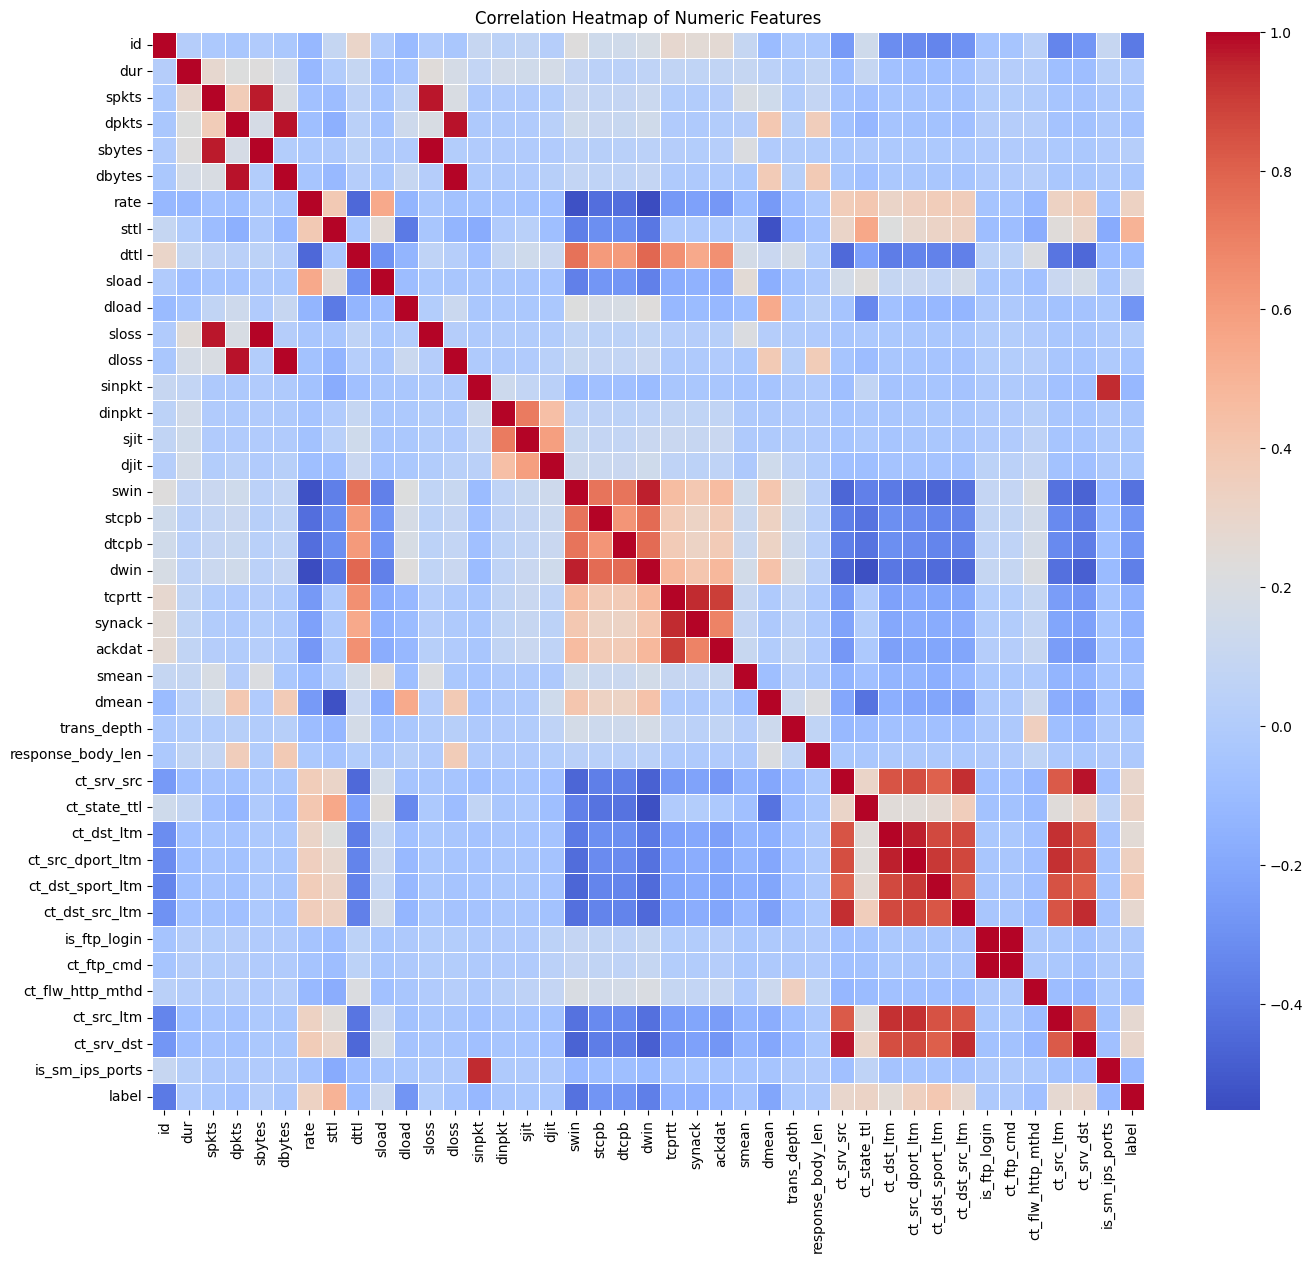

In [ ]:
# Cell 6: Correlation Analysis and Feature Importance
# Select only numeric columns for correlation analysis
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
correlation = train_df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Cell 7: Encode Categorical Variables
encoder = LabelEncoder()
categorical_cols = ['proto', 'service', 'state', 'attack_cat']  # Adjust based on your dataset

# Create dictionaries to store label mappings for later use
label_mappings = {}

for col in categorical_cols:
    if col in train_df.columns:
        # Fit and transform training data
        train_df[col] = encoder.fit_transform(train_df[col])
        # Store the mapping
        label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

        # Transform test data if the column exists
        if col in test_df.columns:
            # Handle unseen categories in test set
            test_df[col] = test_df[col].map(label_mappings[col]).fillna(-1).astype(int)

# Display label mappings for reference
for col, mapping in label_mappings.items():
    print(f"\nMapping for {col}:")
    for original, encoded in mapping.items():
        print(f"  {original} -> {encoded}")



Mapping for proto:
  3pc -> 0
  a/n -> 1
  aes-sp3-d -> 2
  any -> 3
  argus -> 4
  aris -> 5
  arp -> 6
  ax.25 -> 7
  bbn-rcc -> 8
  bna -> 9
  br-sat-mon -> 10
  cbt -> 11
  cftp -> 12
  chaos -> 13
  compaq-peer -> 14
  cphb -> 15
  cpnx -> 16
  crtp -> 17
  crudp -> 18
  dcn -> 19
  ddp -> 20
  ddx -> 21
  dgp -> 22
  egp -> 23
  eigrp -> 24
  emcon -> 25
  encap -> 26
  etherip -> 27
  fc -> 28
  fire -> 29
  ggp -> 30
  gmtp -> 31
  gre -> 32
  hmp -> 33
  i-nlsp -> 34
  iatp -> 35
  ib -> 36
  idpr -> 37
  idpr-cmtp -> 38
  idrp -> 39
  ifmp -> 40
  igmp -> 41
  igp -> 42
  il -> 43
  ip -> 44
  ipcomp -> 45
  ipcv -> 46
  ipip -> 47
  iplt -> 48
  ipnip -> 49
  ippc -> 50
  ipv6 -> 51
  ipv6-frag -> 52
  ipv6-no -> 53
  ipv6-opts -> 54
  ipv6-route -> 55
  ipx-n-ip -> 56
  irtp -> 57
  isis -> 58
  iso-ip -> 59
  iso-tp4 -> 60
  kryptolan -> 61
  l2tp -> 62
  larp -> 63
  leaf-1 -> 64
  leaf-2 -> 65
  merit-inp -> 66
  mfe-nsp -> 67
  mhrp -> 68
  micp -> 69
  mobile -> 70
  

In [ ]:
# Cell 8: Feature Selection
# Select features based on dataset columns excluding target variables
exclude_cols = ['srcip', 'dstip', 'Stime', 'Ltime', 'attack_cat', 'Label']
features = [col for col in train_df.columns if col not in exclude_cols]

print("Selected features:", features)
print("Number of features:", len(features))

# Separate features (X) and target (y)
X_train = train_df[features]
y_train = train_df['label']

X_test = test_df[features]
y_test = test_df['label']


Selected features: ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']
Number of features: 44


In [ ]:
# Cell 9: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use
joblib.dump(scaler, drive_path + "scaler.pkl")
print("Scaler saved to drive")


Scaler saved to drive


In [ ]:
# Cell 10: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Original training set shape:", X_train_scaled.shape)
print("Resampled training set shape:", X_train_resampled.shape)
print("Original class distribution:", np.bincount(y_train))
print("Resampled class distribution:", np.bincount(y_train_resampled))

# Don't apply SMOTE to test set (preserving original distribution)

Original training set shape: (82332, 44)
Resampled training set shape: (90664, 44)
Original class distribution: [37000 45332]
Resampled class distribution: [45332 45332]


In [ ]:
# Cell 11: Hyperparameter Tuning for Random Forest (as an example)
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for faster tuning
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_random.fit(X_train_resampled, y_train_resampled)

# Print the best parameters
print("Best parameters:", rf_random.best_params_)
best_rf = rf_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}


In [ ]:
# Cell 12: Define and Train Models
models = {
    'Random Forest': best_rf,  # Use the tuned RF model
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Dictionary to store results
results = {}
model_predictions = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    # Skip training for Random Forest as it's already trained
    if model_name != 'Random Forest':
        model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    model_predictions[model_name] = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC Curve
    if hasattr(model, "predict_proba"):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
        roc_auc = auc(fpr, tpr)
    else:
        roc_auc = 0

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Training time
    training_time = time.time() - start_time

    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'training_time': training_time
    }

    # Save model
    joblib.dump(model, drive_path + f"{model_name.replace(' ', '_')}_model.pkl")
    print(f"{model_name} trained and saved in {training_time:.2f} seconds")



Training Random Forest...
Random Forest trained and saved in 2.40 seconds

Training Gradient Boosting...
Gradient Boosting trained and saved in 35.89 seconds

Training AdaBoost...
AdaBoost trained and saved in 0.37 seconds

Training Support Vector Machine...
Support Vector Machine trained and saved in 99.87 seconds

Training K-Nearest Neighbors...
K-Nearest Neighbors trained and saved in 254.28 seconds

Training Decision Tree...
Decision Tree trained and saved in 0.49 seconds

Training XGBoost...
XGBoost trained and saved in 1.30 seconds



Model Performance Comparison:
                        accuracy  f1_score   roc_auc  training_time
Random Forest           1.000000  1.000000  1.000000       2.401034
Gradient Boosting       1.000000  1.000000  1.000000      35.885059
AdaBoost                1.000000  1.000000  1.000000       0.369744
XGBoost                 1.000000  1.000000  1.000000       1.295517
Decision Tree           1.000000  1.000000  1.000000       0.488838
Support Vector Machine  0.997268  0.997994  0.999032      99.866660
K-Nearest Neighbors     0.877302  0.901513  0.937354     254.276651


<Figure size 1200x800 with 0 Axes>

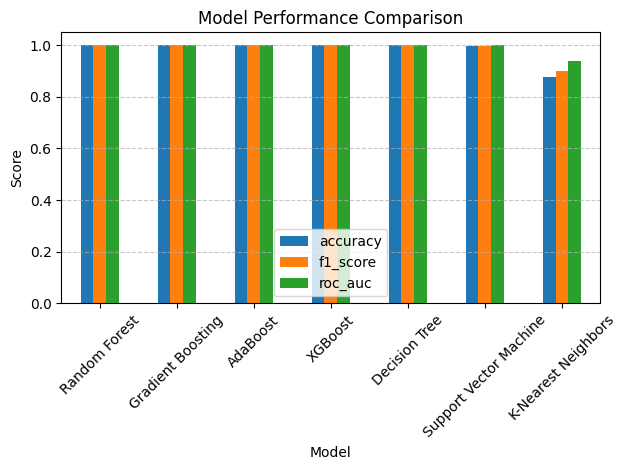


The Best Model is: Random Forest
Best Model Accuracy: 1.0000
Best Model F1 Score: 1.0000
Best Model ROC AUC: 1.0000


In [ ]:
# Cell 13: Compare Models and Visualize Results
# Create DataFrame from results
metrics = ['accuracy', 'f1_score', 'roc_auc', 'training_time']
results_df = pd.DataFrame({model: [results[model][metric] for metric in metrics]
                           for model in results.keys()}, index=metrics)

# Transpose for better readability
results_df = results_df.T.sort_values(by='roc_auc', ascending=False)
print("\nModel Performance Comparison:")
print(results_df)

# Visualize performance metrics
plt.figure(figsize=(12, 8))
results_df[['accuracy', 'f1_score', 'roc_auc']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Get the best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"\nThe Best Model is: {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Best Model F1 Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Best Model ROC AUC: {results[best_model_name]['roc_auc']:.4f}")


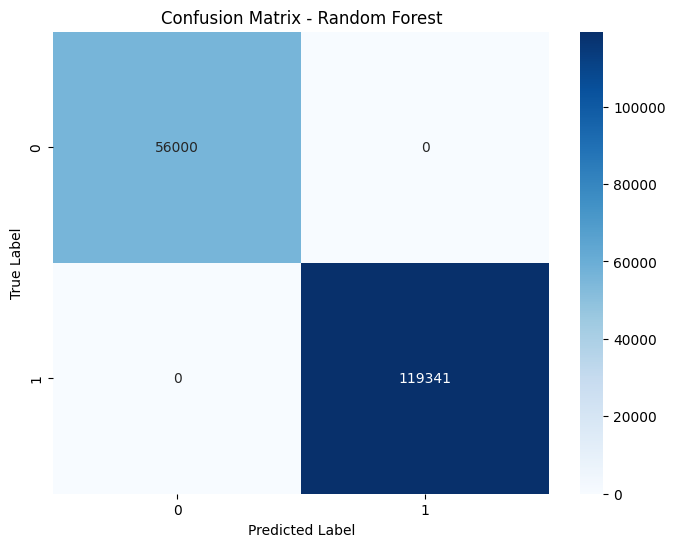


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



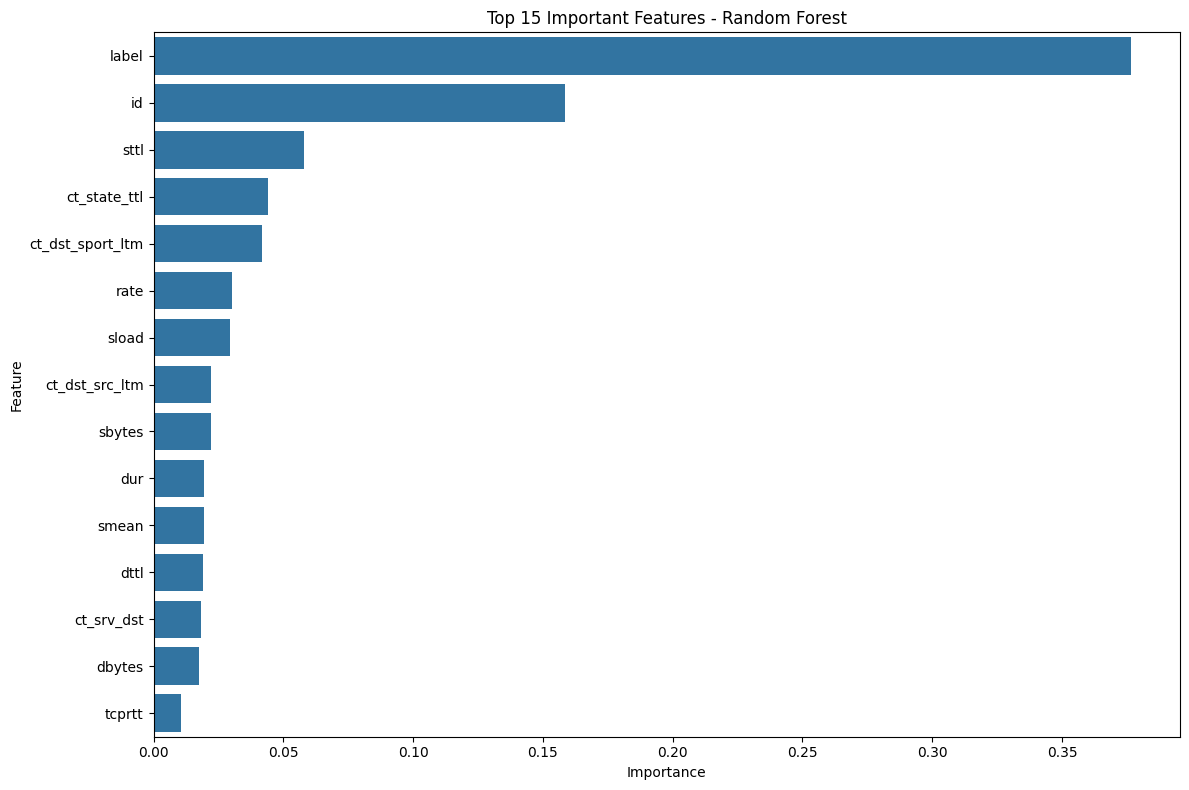


Top 10 Most Important Features:
             Feature  Importance
43             label    0.376628
0                 id    0.158348
10              sttl    0.058001
32      ct_state_ttl    0.043962
35  ct_dst_sport_ltm    0.041944
9               rate    0.030312
12             sload    0.029634
36    ct_dst_src_ltm    0.022176
7             sbytes    0.022004
1                dur    0.019482


In [ ]:
# Cell 14: Generate Detailed Analysis for Best Model
# Visualize Confusion Matrix for best model
plt.figure(figsize=(8, 6))
cm = results[best_model_name]['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print Classification Report
y_pred = model_predictions[best_model_name]
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Important Features - {best_model_name}')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

In [85]:
# Cell 15: Advanced UI for Prediction
def create_prediction_ui():
    # Create tabs for different input methods
    tab = widgets.Tab()

    # Tab 1: Manual Input for Key Features
    manual_input_widgets = {}

    # Only include top important features and mandatory ones
    if hasattr(best_model, 'feature_importances_'):
        top_features = feature_importance.head(10)['Feature'].tolist()
    else:
        top_features = features[:10]  # Take first 10 if no importance available

    # Add key protocol features
    for feature in ['proto', 'service', 'state']:
        if feature in features:
            if feature not in top_features:
                top_features.append(feature)

    # Create input widgets for top features
    for feature in top_features:
        if feature in categorical_cols:
            options = label_mappings.get(feature, {})
            manual_input_widgets[feature] = widgets.Dropdown(
                description=feature,
                options=[(k, v) for k, v in options.items()],
                value=list(options.values())[0] if options else 0
            )
        else:
            manual_input_widgets[feature] = widgets.FloatText(
                description=feature,
                value=0.0
            )

    # Organize manual input widgets into a layout
    manual_box = widgets.VBox([widgets.Label("Enter values for key features:"),
                              *list(manual_input_widgets.values())])

    # Tab 2: Preset Attack Scenarios
    attack_scenarios = {
        "DoS Attack": {
            'proto': 0,  # Assuming 0 is TCP in your encoding
            'service': label_mappings.get('service', {}).get('http', 0),
            'state': label_mappings.get('state', {}).get('CON', 0),
            'dur': 0.1,
            'sbytes': 1500,
            'dbytes': 0,
            'ct_srv_src': 100,
            'ct_srv_dst': 100
        },
        "Port Scan": {
            'proto': 0,  # TCP
            'service': label_mappings.get('service', {}).get('-', 0),
            'state': label_mappings.get('state', {}).get('REQ', 0),
            'dur': 0.001,
            'sbytes': 50,
            'dbytes': 0,
            'ct_dst_sport_ltm': 80
        },
        "Brute Force": {
            'proto': 0,  # TCP
            'service': label_mappings.get('service', {}).get('ssh', 0),
            'state': label_mappings.get('state', {}).get('CON', 0),
            'dur': 0.5,
            'sbytes': 300,
            'dbytes': 800,
            'ct_src_dport_ltm': 50
        }
    }

    # Create radio buttons for scenario selection
    scenario_selector = widgets.RadioButtons(
        options=list(attack_scenarios.keys()),
        description='Select Scenario:',
        disabled=False
    )

    scenario_box = widgets.VBox([scenario_selector])

    # Tab 3: Batch Prediction
    batch_file_upload = widgets.FileUpload(
        accept='.csv',
        multiple=False,
        description='Upload CSV:'
    )

    batch_box = widgets.VBox([batch_file_upload])

    # Create tab children
    tab.children = [manual_box, scenario_box, batch_box]
    tab.set_title(0, 'Manual Input')
    tab.set_title(1, 'Attack Scenarios')
    tab.set_title(2, 'Batch Prediction')

    # Prediction button
    predict_button = widgets.Button(
        description='Predict',
        disabled=False,
        button_style='success',
        tooltip='Click to predict',
        icon='check'
    )

    # Output area
    output = widgets.Output()

    # Create progress bar for batch processing
    progress = widgets.IntProgress(
        value=0,
        min=0,
        max=10,
        description='Progress:',
        bar_style='info',
        style={'bar_color': '#0077b6'},
        orientation='horizontal'
    )

    # Function to prepare features from widgets
    def get_features_from_widgets(widget_dict):
        return {feature: widget.value for feature, widget in widget_dict.items()}

    # Function to prepare complete feature vector
    def prepare_feature_vector(input_dict):
        feature_vector = pd.DataFrame(columns=features)
        for col in features:
            feature_vector[col] = [input_dict.get(col, 0)]
        return feature_vector

    # Function to handle prediction button click
    def on_predict_button_clicked(b):
        with output:
            output.clear_output()

            # Get active tab
            active_tab = tab.selected_index

            if active_tab == 0:  # Manual Input
                # Get values from widgets
                input_dict = get_features_from_widgets(manual_input_widgets)

                # Prepare feature vector
                feature_vector = prepare_feature_vector(input_dict)

                # Scale input data
                feature_vector_scaled = scaler.transform(feature_vector)

                # Make prediction
                prediction = best_model.predict(feature_vector_scaled)[0]

                # Display result
                if prediction == 1:
                    display(HTML("<h3 style='color: red;'>⚠️ ATTACK DETECTED ⚠️</h3>"))
                else:
                    display(HTML("<h3 style='color: green;'>✓ Normal Traffic</h3>"))

                # Show probability if available
                if hasattr(best_model, 'predict_proba'):
                    proba = best_model.predict_proba(feature_vector_scaled)[0][1]
                    display(HTML(f"<p>Attack probability: <b>{proba:.2%}</b></p>"))

                # Show input values for verification
                print("\nInput Values:")
                for feature, value in input_dict.items():
                    print(f"{feature}: {value}")

            elif active_tab == 1:  # Attack Scenarios
                # Get selected scenario
                scenario_name = scenario_selector.value
                scenario_data = attack_scenarios[scenario_name]

                # Prepare feature vector
                feature_vector = prepare_feature_vector(scenario_data)

                # Scale input data
                feature_vector_scaled = scaler.transform(feature_vector)

                # Make prediction
                prediction = best_model.predict(feature_vector_scaled)[0]

                # Display result with scenario information
                display(HTML(f"<h3>Scenario: {scenario_name}</h3>"))

                if prediction == 1:
                    display(HTML("<h3 style='color: red;'>⚠️ ATTACK DETECTED ⚠️</h3>"))
                else:
                    display(HTML("<h3 style='color: green;'>✓ Normal Traffic</h3>"))

                # Show probability if available
                if hasattr(best_model, 'predict_proba'):
                    proba = best_model.predict_proba(feature_vector_scaled)[0][1]
                    display(HTML(f"<p>Attack probability: <b>{proba:.2%}</b></p>"))

                # Show scenario values for verification
                print("\nScenario Values:")
                for feature, value in scenario_data.items():
                    print(f"{feature}: {value}")

            elif active_tab == 2:  # Batch Prediction
                # Check if file was uploaded
                if not batch_file_upload.value:
                    print("Please upload a CSV file first")
                    return

                # Get uploaded file
                uploaded_file = list(batch_file_upload.value.values())[0]

                # Convert to pandas DataFrame
                content = uploaded_file['content']
                batch_df = pd.read_csv(io.BytesIO(content))

                # Check if required features are present
                missing_features = [col for col in features if col not in batch_df.columns]
                if missing_features:
                    print(f"Error: Missing features in uploaded file: {missing_features}")
                    return

                # Update progress bar
                progress.max = len(batch_df)
                progress.value = 0
                display(progress)

                # Process batch
                batch_df_features = batch_df[features]
                batch_df_scaled = scaler.transform(batch_df_features)
                predictions = best_model.predict(batch_df_scaled)

                # Add predictions to DataFrame
                batch_df['prediction'] = predictions

                if hasattr(best_model, 'predict_proba'):
                    batch_df['attack_probability'] = best_model.predict_proba(batch_df_scaled)[:, 1]

                # Display summary
                attack_count = sum(predictions)
                normal_count = len(predictions) - attack_count

                display(HTML(f"""
                <h3>Batch Prediction Results</h3>
                <p>Processed {len(predictions)} records</p>
                <p>Detected <span style='color:red'>{attack_count}</span> potential attacks</p>
                <p>Identified <span style='color:green'>{normal_count}</span> normal traffic records</p>
                """))

                # Update progress bar to complete
                progress.value = progress.max

                # Display head of results
                print("\nSample of predictions:")
                display(batch_df.head(10))

                # Add option to download results
                timestamp = time.strftime("%Y%m%d-%H%M%S")
                result_path = drive_path + f"batch_results_{timestamp}.csv"
                batch_df.to_csv(result_path, index=False)
                print(f"\nResults saved to Google Drive: {result_path}")

    # Connect the button to the function
    predict_button.on_click(on_predict_button_clicked)

    # Display the UI
    display(tab, predict_button, output)


In [86]:
# Monitoring function
def monitor_traffic(start_time):
    # Check if monitoring should continue
    if not hasattr(monitor_traffic, 'running') or not monitor_traffic.running:
        return

    with output:
        # Generate a synthetic traffic record
        traffic_type = np.random.choice(['normal', 'attack'], p=[0.8, 0.2])

        # Default attack_type for all traffic
        attack_type = 'normal'

        if traffic_type == 'normal':
            # Generate normal traffic
            record = {
                'proto': np.random.choice([0, 1, 2]),  # Random protocols
                'service': np.random.choice([0, 1, 2, 3]),  # Random services
                'state': np.random.choice([0, 1, 2]),  # Random states
                'dur': np.random.uniform(0.01, 1.0),
                'sbytes': np.random.randint(100, 1000),
                'dbytes': np.random.randint(100, 1000),
                'swin': np.random.randint(1000, 10000),
                'dwin': np.random.randint(1000, 10000),
                'stcpb': np.random.randint(1000, 10000),
                'dtcpb': np.random.randint(1000, 10000)
            }
            # Fill in other features with random values
            for feature in features:
                if feature not in record:
                    record[feature] = np.random.randint(0, 100)
        else:
            # Generate attack traffic (more extreme values)
            attack_type = np.random.choice(['dos', 'scan', 'exploit'])

            if attack_type == 'dos':
                record = {
                    'proto': 0,  # TCP
                    'service': 0,  # HTTP
                    'state': 1,  # CON
                    'dur': np.random.uniform(0.01, 0.1),
                    'sbytes': np.random.randint(1000, 5000),
                    'dbytes': np.random.randint(0, 500),
                    'swin': np.random.randint(8000, 10000),
                    'dwin': np.random.randint(1000, 5000),
                    'ct_srv_src': np.random.randint(90, 100),
                    'ct_srv_dst': np.random.randint(90, 100)
                }
            elif attack_type == 'scan':
                record = {
                    'proto': 0,  # TCP
                    'service': 4,  # '-'
                    'state': 3,  # REQ
                    'dur': np.random.uniform(0.001, 0.01),
                    'sbytes': np.random.randint(30, 60),
                    'dbytes': 0,
                    'ct_dst_sport_ltm': np.random.randint(70, 90)
                }
            else:  # exploit
                record = {
                    'proto': 0,  # TCP
                    'service': 2,  # SSH
                    'state': 1,  # CON
                    'dur': np.random.uniform(0.5, 2.0),
                    'sbytes': np.random.randint(300, 600),
                    'dbytes': np.random.randint(600, 1000),
                    'ct_src_dport_ltm': np.random.randint(40, 60)
                }

            # Fill in other features with random values
            for feature in features:
                if feature not in record:
                    record[feature] = np.random.randint(0, 100)

        # Create a DataFrame
        df = pd.DataFrame([record])

        # Ensure all features are present
        for feature in features:
            if feature not in df.columns:
                df[feature] = 0

        # Scale the input data
        df_scaled = scaler.transform(df[features])

        # Make prediction
        prediction = best_model.predict(df_scaled)[0]

        # Get probability
        if hasattr(best_model, 'predict_proba'):
            probability = best_model.predict_proba(df_scaled)[0][1]
        else:
            probability = 1.0 if prediction == 1 else 0.0

        # Determine if this is an alert
        is_alert = probability >= alert_threshold.value

        # Handle case where model predicts attack but traffic was generated as normal
        if is_alert and traffic_type == 'normal':
            attack_type = 'unknown'

        # Update chart data
        current_time = time.strftime("%H:%M:%S")
        chart_data['timestamps'].append(current_time)

        # Keep only the last 20 points
        if len(chart_data['timestamps']) > 20:
            chart_data['timestamps'] = chart_data['timestamps'][-20:]
            chart_data['normal'] = chart_data['normal'][-20:]
            chart_data['attack'] = chart_data['attack'][-20:]

        # Add new point
        if prediction == 0:
            chart_data['normal'].append(1)
            chart_data['attack'].append(0)
        else:
            chart_data['normal'].append(0)
            chart_data['attack'].append(1)

        # Clear previous output
        output.clear_output(wait=True)

        # Display monitoring information
        elapsed = time.time() - start_time
        minutes, seconds = divmod(int(elapsed), 60)
        hours, minutes = divmod(minutes, 60)

        # Update alert count
        if is_alert:
            alerts['count'] += 1

        # Display summary
        display(HTML(f"""
        <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; margin-bottom: 10px;">
            <h3>Network Traffic Monitoring</h3>
            <p>Running time: {hours:02d}:{minutes:02d}:{seconds:02d}</p>
            <p>Total alerts: <span style="color: red; font-weight: bold;">{alerts['count']}</span></p>
            <p>Alert threshold: {alert_threshold.value:.2f}</p>
        </div>
        """))

        # Display current traffic information
        if is_alert:
            alert_message = f"⚠️ ALERT: Potential {attack_type.upper()} attack detected!"
            display(HTML(f"""
            <div style="background-color: #ffebee; padding: 10px; border-radius: 5px; border: 2px solid red;">
                <h4 style="color: red;">{alert_message}</h4>
                <p>Time: {current_time}</p>
                <p>Attack probability: <b>{probability:.2%}</b></p>
                <p>Protocol: {record['proto']}, Service: {record['service']}, State: {record['state']}</p>
            </div>
            """))
        else:
            display(HTML(f"""
            <div style="background-color: #e8f5e9; padding: 10px; border-radius: 5px;">
                <h4 style="color: green;">✓ Normal Traffic</h4>
                <p>Time: {current_time}</p>
                <p>Detection confidence: <b>{1-probability:.2%}</b></p>
                <p>Protocol: {record['proto']}, Service: {record['service']}, State: {record['state']}</p>
            </div>
            """))

        # Create and display traffic chart
        plt.figure(figsize=(10, 4))
        x = range(len(chart_data['timestamps']))

        plt.bar(x, chart_data['normal'], color='green', alpha=0.6, label='Normal')
        plt.bar(x, chart_data['attack'], color='red', alpha=0.6, label='Attack')

        plt.ylabel('Traffic Type')
        plt.title('Real-time Traffic Classification')
        plt.xticks(x, chart_data['timestamps'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Schedule next update based on speed slider
        interval = 1.0 / speed_slider.value
        if monitor_traffic.running:
            import threading
            threading.Timer(interval, monitor_traffic, [start_time]).start()

In [87]:
# Cell 17: Attack Category Classification
# Create function to train attack category classifier
def train_attack_category_classifier():
    # Only needed if dataset has attack_cat column
    if 'attack_cat' in train_df.columns:
        # Filter only attack records
        attack_df = train_df[train_df['label'] == 1]

        if len(attack_df) == 0:
            print("No attack records found in training data")
            return None

        # Features and target
        X_attack = attack_df[features]
        y_attack = attack_df['attack_cat']

        # Scale features
        X_attack_scaled = scaler.transform(X_attack)

        # Train a RandomForest classifier for attack categories
        cat_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        cat_classifier.fit(X_attack_scaled, y_attack)

        # Save the model
        joblib.dump(cat_classifier, drive_path + "attack_category_classifier.pkl")

        # Evaluate on a sample of the data
        from sklearn.model_selection import cross_val_score
        cv_scores = cross_val_score(cat_classifier, X_attack_scaled, y_attack, cv=5)
        print(f"Attack category classifier trained. Cross-validation accuracy: {cv_scores.mean():.4f}")

        return cat_classifier
    else:
        print("Dataset does not contain attack categories")
        return None

# Call the function
attack_cat_classifier = train_attack_category_classifier()

Attack category classifier trained. Cross-validation accuracy: 0.7346


In [88]:
# Cell 18: Create a Comprehensive Dashboard
def create_dashboard():
    # Create tabs for different sections
    tab = widgets.Tab()

    # Tab 1: Model Performance Overview
    performance_output = widgets.Output()
    with performance_output:
        # Display model comparison chart
        plt.figure(figsize=(12, 8))
        results_df[['accuracy', 'f1_score', 'roc_auc']].plot(kind='bar')
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

        # Display metrics table
        display(HTML("<h3>Model Performance Metrics</h3>"))
        display(results_df.style.background_gradient(cmap='Blues'))

        # Best model details
        display(HTML(f"<h3>Best Model: {best_model_name}</h3>"))

        # Display confusion matrix
        plt.figure(figsize=(8, 6))
        cm = results[best_model_name]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {best_model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    # Tab 2: Feature Analysis
    feature_output = widgets.Output()
    with feature_output:
        # Feature importance
        if hasattr(best_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'Feature': features,
                'Importance': best_model.feature_importances_
            }).sort_values(by='Importance', ascending=False)

            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
            plt.title(f'Top 15 Important Features - {best_model_name}')
            plt.tight_layout()
            plt.show()

            # Feature correlation heatmap
            plt.figure(figsize=(16, 14))
            top_features = feature_importance.head(10)['Feature'].tolist()
            top_features_corr = train_df[top_features].corr()
            sns.heatmap(top_features_corr, annot=True, cmap='coolwarm', linewidths=0.5)
            plt.title('Correlation Between Top Features')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

            # Feature distributions
            plt.figure(figsize=(16, 12))
            for i, feature in enumerate(top_features[:6]):  # Show top 6 features
                plt.subplot(2, 3, i+1)
                sns.histplot(
                    train_df, x=feature, hue='label',
                    element='step', stat='density', common_norm=False
                )
                plt.title(f'Distribution of {feature}')
            plt.tight_layout()
            plt.show()

    # Tab 3: Attack Analysis
    attack_output = widgets.Output()
    with attack_output:
        if 'attack_cat' in train_df.columns:
            # Attack category distribution
            plt.figure(figsize=(12, 6))
            attack_df = train_df[train_df['label'] == 1]
            attack_counts = attack_df['attack_cat'].value_counts()
            attack_counts.plot(kind='bar', color='crimson')
            plt.title('Distribution of Attack Categories')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Attack categories by protocol
            plt.figure(figsize=(14, 8))
            protocol_attack = pd.crosstab(attack_df['proto'], attack_df['attack_cat'])
            protocol_attack.plot(kind='bar', stacked=True, colormap='tab20')
            plt.title('Attack Categories by Protocol')
            plt.xlabel('Protocol')
            plt.ylabel('Count')
            plt.legend(title='Attack Category', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

            # Attack categories by service
            plt.figure(figsize=(14, 8))
            service_attack = pd.crosstab(attack_df['service'], attack_df['attack_cat'])
            service_attack.plot(kind='bar', stacked=True, colormap='tab20')
            plt.title('Attack Categories by Service')
            plt.xlabel('Service')
            plt.ylabel('Count')
            plt.legend(title='Attack Category', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
        else:
            display(HTML("<h3>Attack category analysis not available - missing 'attack_cat' column</h3>"))

    # Tab 4: Prediction Interface
    prediction_output = widgets.Output()
    with prediction_output:
        create_prediction_ui()

    # Tab 5: Monitoring Simulation
    monitoring_output = widgets.Output()
    with monitoring_output:
        create_monitoring_ui()

    # Create tab children
    tab.children = [performance_output, feature_output, attack_output, prediction_output, monitoring_output]
    tab.set_title(0, 'Model Performance')
    tab.set_title(1, 'Feature Analysis')
    tab.set_title(2, 'Attack Analysis')
    tab.set_title(3, 'Prediction')
    tab.set_title(4, 'Monitoring')

    # Display the dashboard
    display(tab)


In [89]:
# Cell 19: Create Advanced Traffic Visualization
def create_traffic_visualization():
    # Define a sample of traffic (or use a subset of your dataset)
    if len(train_df) > 1000:
        sample_df = train_df.sample(1000, random_state=42)
    else:
        sample_df = train_df.copy()

    # Prepare nodes and links for network graph
    nodes = set()
    links = []

    # Create edges from source to destination IPs if available
    if 'srcip' in sample_df.columns and 'dstip' in sample_df.columns:
        for _, row in sample_df.iterrows():
            src = str(row['srcip'])
            dst = str(row['dstip'])
            nodes.add(src)
            nodes.add(dst)
            links.append((src, dst, row['label']))
    else:
        # Create sample nodes and links for visualization purpose
        # Generate IPs for different services
        services = sample_df['service'].unique()
        service_ips = {service: f"10.0.0.{i+1}" for i, service in enumerate(services)}

        # Generate random client IPs
        client_ips = [f"192.168.1.{i}" for i in range(1, 21)]

        for i, row in sample_df.iterrows():
            # Skip some rows to reduce density
            if i % 5 != 0:
                continue

            src = np.random.choice(client_ips)
            service = row['service']
            dst = service_ips.get(service, "10.0.0.99")

            nodes.add(src)
            nodes.add(dst)
            links.append((src, dst, row['label']))

    # Create networkx graph
    import networkx as nx
    G = nx.DiGraph()

    # Add nodes with attributes
    for node in nodes:
        G.add_node(node)

    # Add edges with attributes
    for src, dst, label in links:
        # Color based on label (red for attack, green for normal)
        color = 'red' if label == 1 else 'green'
        G.add_edge(src, dst, color=color, weight=2)

    # Position nodes using a spring layout
    pos = nx.spring_layout(G, k=0.15, iterations=20)

    # Create matplotlib figure
    plt.figure(figsize=(15, 10))

    # Draw normal traffic edges
    normal_edges = [(u, v) for u, v, d in G.edges(data=True) if d['color'] == 'green']
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='green',
                          alpha=0.5, arrows=True, width=1)

    # Draw attack traffic edges
    attack_edges = [(u, v) for u, v, d in G.edges(data=True) if d['color'] == 'red']
    nx.draw_networkx_edges(G, pos, edgelist=attack_edges, edge_color='red',
                          alpha=0.7, arrows=True, width=2)

    # Draw nodes with different colors for clients and servers
    client_nodes = [n for n in G.nodes() if n.startswith('192')]
    server_nodes = [n for n in G.nodes() if not n.startswith('192')]

    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes, node_color='skyblue',
                          alpha=0.8, node_size=50)
    nx.draw_networkx_nodes(G, pos, nodelist=server_nodes, node_color='orange',
                          alpha=0.8, node_size=100)

    # Add a small random sample of labels to avoid overcrowding
    label_nodes = list(G.nodes())
    if len(label_nodes) > 20:
        label_nodes = np.random.choice(label_nodes, 20, replace=False)
    node_labels = {n: n for n in label_nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

    plt.title("Network Traffic Visualization (Red = Attack Traffic, Green = Normal Traffic)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [90]:
# Cell 20: Machine Learning Model Explanation with SHAP
def explain_model_with_shap():
    try:
        import shap

        # Check if the model can be explained with SHAP
        if hasattr(best_model, 'predict_proba'):
            # Create explainer (only for tree-based models)
            if hasattr(best_model, 'estimators_') or hasattr(best_model, 'feature_importances_'):
                # Sample data for explanation
                X_sample = X_test_scaled[:100]  # Use a smaller sample for speed

                # Create explainer
                if best_model_name == 'XGBoost':
                    explainer = shap.TreeExplainer(best_model)
                else:
                    explainer = shap.TreeExplainer(best_model)

                # Calculate SHAP values
                shap_values = explainer.shap_values(X_sample)

                # Summary plot
                plt.figure(figsize=(12, 8))
                if isinstance(shap_values, list):
                    # For multi-class models
                    shap.summary_plot(shap_values[1], X_sample, feature_names=features)
                else:
                    # For binary models
                    shap.summary_plot(shap_values, X_sample, feature_names=features)

                # Force plot for first instance (attack and normal)
                attack_idx = np.where(y_test[:100] == 1)[0][0]
                normal_idx = np.where(y_test[:100] == 0)[0][0]

                # Attack example
                plt.figure(figsize=(14, 4))
                if isinstance(shap_values, list):
                    # For multi-class models
                    shap.force_plot(explainer.expected_value[1],
                                 shap_values[1][attack_idx,:],
                                 X_sample[attack_idx,:],
                                 feature_names=features,
                                 matplotlib=True,
                                 show=True)
                else:
                    # For binary models
                    shap.force_plot(explainer.expected_value,
                                 shap_values[attack_idx,:],
                                 X_sample[attack_idx,:],
                                 feature_names=features,
                                 matplotlib=True,
                                 show=True)
                plt.title("SHAP Force Plot (Attack Example)")

                # Normal example
                plt.figure(figsize=(14, 4))
                if isinstance(shap_values, list):
                    # For multi-class models
                    shap.force_plot(explainer.expected_value[1],
                                 shap_values[1][normal_idx,:],
                                 X_sample[normal_idx,:],
                                 feature_names=features,
                                 matplotlib=True,
                                 show=True)
                else:
                    # For binary models
                    shap.force_plot(explainer.expected_value,
                                 shap_values[normal_idx,:],
                                 X_sample[normal_idx,:],
                                 feature_names=features,
                                 matplotlib=True,
                                 show=True)
                plt.title("SHAP Force Plot (Normal Example)")

                # Dependence plots for top features
                if hasattr(best_model, 'feature_importances_'):
                    top_features = feature_importance.head(3)['Feature'].tolist()

                    plt.figure(figsize=(15, 10))
                    for i, feature in enumerate(top_features):
                        plt.subplot(1, 3, i+1)
                        feature_idx = features.index(feature)
                        if isinstance(shap_values, list):
                            shap.dependence_plot(feature_idx, shap_values[1], X_sample,
                                            feature_names=features, ax=plt.gca())
                        else:
                            shap.dependence_plot(feature_idx, shap_values, X_sample,
                                            feature_names=features, ax=plt.gca())
                    plt.tight_layout()

            else:
                print("SHAP explanation not available for this model type")
        else:
            print("Model does not support probability estimates required for SHAP")
    except ImportError:
        print("SHAP library not installed. Install it with: !pip install shap")
    except Exception as e:
        print(f"Error creating SHAP explanations: {e}")

In [91]:
# Cell 21: Call the main functions to execute the dashboard
# Uncomment the function you want to execute
# create_dashboard()
# create_traffic_visualization()
# explain_model_with_shap()

print("""
Network Attack Detection System is ready!

To use the system, run any of the following cells:
1. To view the complete dashboard:
   create_dashboard()

2. To visualize network traffic:
   create_traffic_visualization()

3. To explain model predictions:
   explain_model_with_shap()

4. To use just the prediction interface:
   create_prediction_ui()

5. To use just the monitoring simulation:
   create_monitoring_ui()
""")


Network Attack Detection System is ready!

To use the system, run any of the following cells:
1. To view the complete dashboard:
   create_dashboard()

2. To visualize network traffic:
   create_traffic_visualization()

3. To explain model predictions:
   explain_model_with_shap()

4. To use just the prediction interface:
   create_prediction_ui()

5. To use just the monitoring simulation:
   create_monitoring_ui()



In [92]:
create_dashboard()

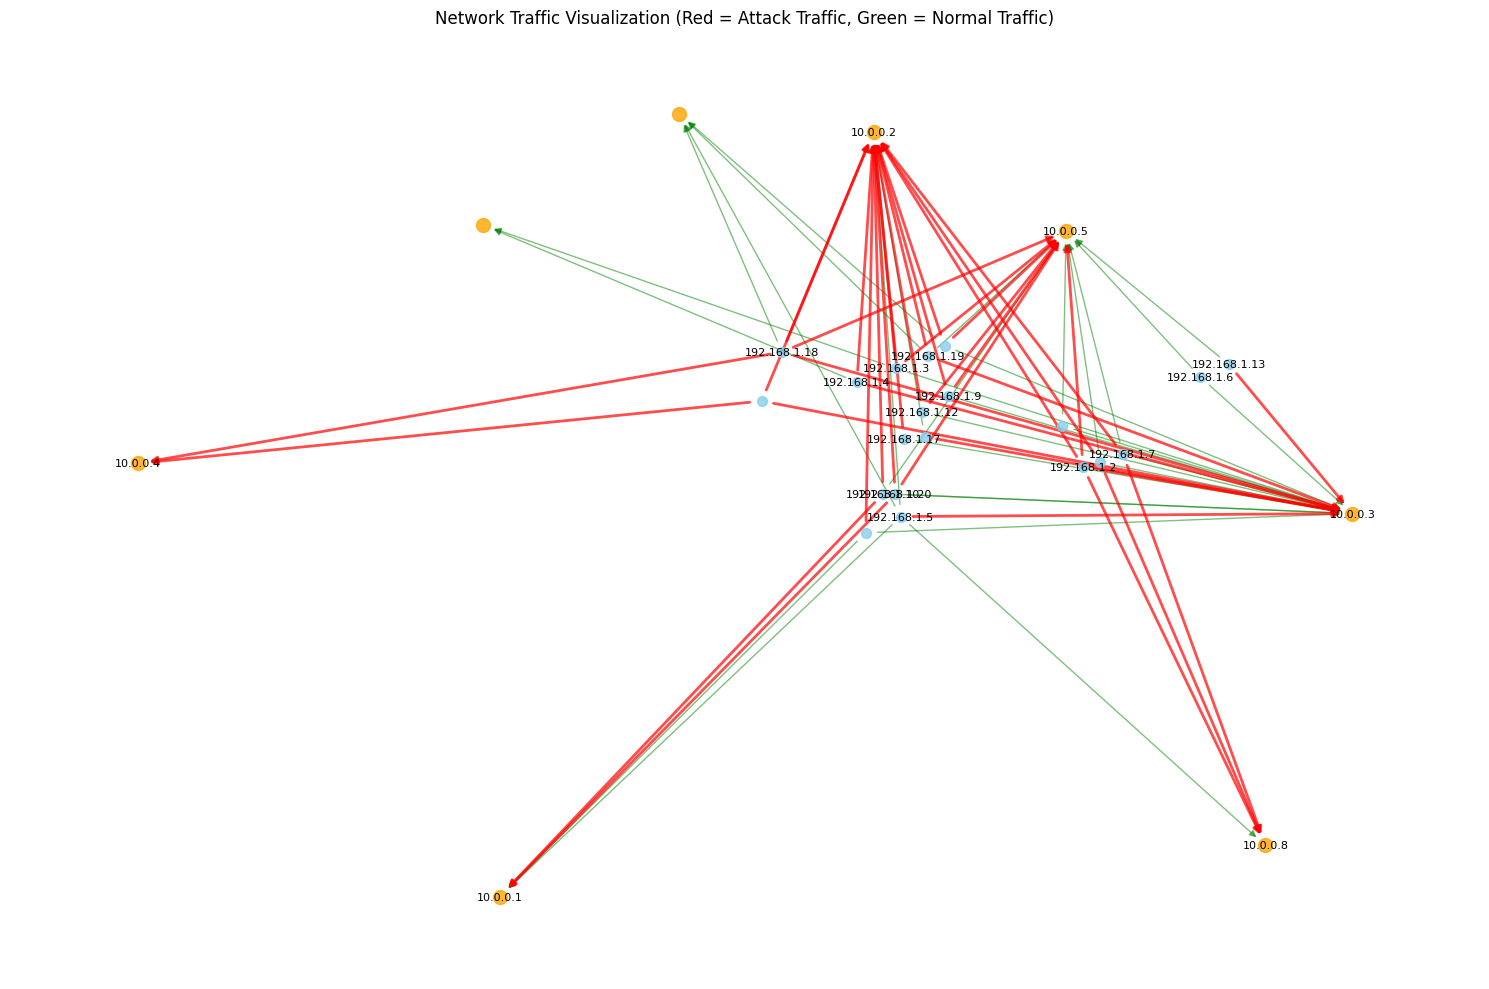

In [ ]:
create_traffic_visualization()

<Figure size 1200x800 with 0 Axes>

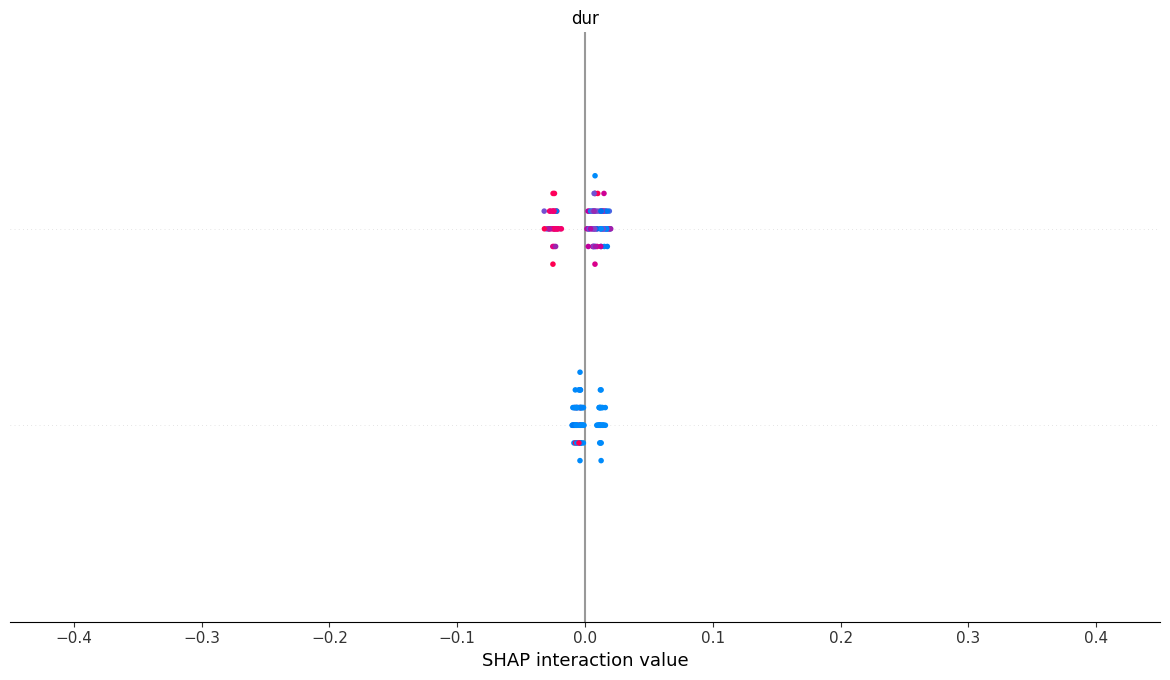

Error creating SHAP explanations: index 0 is out of bounds for axis 0 with size 0


In [93]:
explain_model_with_shap()


In [94]:
create_prediction_ui()

Button(button_style='success', description='Predict', icon='check', style=ButtonStyle(), tooltip='Click to pre…

Output()

In [96]:
create_monitoring_ui()